## Exploring the MPC's Isolated Tracklet File
#### Matt Holman, Matt Payne, Paul Blankley, Ryan Janssen


1 December 2017

This notebook is intended to be a consolidation of the material that is in ITF_mjh_20171201.ipynb and ITF_mjh.ipynb

The plan is to:

    * Remove unused routines.
    * Select a final, working approach.
    * Set up training/test routines.
    * Set up routines to run on the full ITF.


### The NOVAS package

First, get the USNO's python NOVAS package.  We'll need that.

http://aa.usno.navy.mil/software/novas/novas_py/novaspy_intro.php

Just type 

pip install novas

pip install novas_de405

Here's the reference:

Barron, E. G., Kaplan, G. H., Bangert, J., Bartlett, J. L., Puatua, W., Harris, W., & Barrett, P. (2011) “Naval Observatory Vector Astrometry Software (NOVAS) Version 3.1, Introducing a Python Edition,” Bull. AAS, 43, 2011.

### The kepcart library

You will need to make sure you have a copy of the kepcart library.  There is a copy of it on the MPC bitbucket site, with some instructions.

In [1]:
%matplotlib inline
import numpy as np
import scipy.interpolate
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.notebook_repr_html', True)
import math
import kepcart as kc
import healpy as hp
import collections
import astropy
from collections import defaultdict
from collections import Counter
import MPC_library
import scipy.spatial
import pickle
from operator import add

Observatories = MPC_library.Observatories

ObservatoryXYZ = Observatories.ObservatoryXYZ

### Reading the MPC observation files

Dealing with files line by line in python is not fast.  

The itf.txt, NumObs.txt, and UnnObs.txt files have a mix of 1-line and 2-line formats.  


In [2]:
# This routine checks the 80-character input line to see if it contains a special character (S, R, or V) that indicates a 2-line 
# record.
def is_two_line(line):
    note2 = line[14]
    return note2=='S' or note2=='R' or note2=='V'

In [3]:
# This routine opens and reads filename, separating the records into those in the 1-line and 2-line formats.
# The 2-line format lines are merged into single 160-character records for processing line-by-line.
def split_MPC_file(filename):
    filename_1_line = filename.rstrip('.txt')+"_1_line.txt"
    filename_2_line = filename.rstrip('.txt')+"_2_line.txt"
    with open(filename_1_line, 'w') as f1_out, open(filename_2_line, 'w') as f2_out:
        line1=None
        with open(filename, 'r') as f:
            for line in f:
                if is_two_line(line):
                    line1=line
                    continue
                if line1 != None:
                    merged_lines = line1.rstrip('\n') + line
                    f2_out.write(merged_lines)
                    line1 = None
                else:
                    f1_out.write(line)
                    line1 = None


Now split the files for the three main MPC observation files.  (Need to convert the section below to code from markdown, if you haven't run it already.)

Removed the 2-line observations, for now.

split_MPC_file('itf_new.txt')

Below are routines that read the files after they have been split into their respective formats.  

In [4]:
def readMPC_1_line(filename='NumObs_1_line.txt', nrows=1000000):
    colspecs = [(0, 5), (5, 12), (12, 13), (13, 14), (14, 15), (15, 32), (32, 44), (44, 56), (65, 71), (77, 80)]
    colnames = ['objName', 'provDesig', 'disAst', 'note1', 'note2', 'dateObs', 'RA', 'Dec', 'MagFilter', 'obsCode']
    df = pd.read_fwf(filename, colspecs=colspecs, names=colnames, header=None, nrows=nrows)
    return df

In [5]:
def convertObs80(line):
    objName   = line[0:5]
    provDesig = line[5:12]
    disAst    = line[12:13]
    note1     = line[13:14]
    note2     = line[14:15]
    dateObs   = line[15:32]
    RA        = line[32:44]
    Dec       = line[44:56]
    mag       = line[65:70]
    filt      = line[70:71]
    obsCode   = line[77:80]
    return objName, provDesig, disAst, note1, note2, dateObs, RA, Dec, mag, filt, obsCode


In [6]:
def splitMagFilter(magFilter):
    pieces = magFilter.split()
    if len(pieces)==0:
        return None, None
    elif len(pieces)==1:
         return pieces[0], None
    else:
        return pieces[0], pieces[1]

        

Here I am generating a version of the MPC data that includes just the few string-like fields at the start of each line, followed by jd_tdb, the unit vector to the observed target, and the heliocentric position vector of the observatory at that time.

Here I am generating smaller input files, small enough to be hosted on the github repositort.

CS0051 had a typo on the magnitude, a missing '.' in the number.  I corrected that manually.

We need to preserve tracklets across the time and space boundaries.  That means that the division into time slices and spatial regions should be based on the first member of a tracklet only.  That way the full tracklet is accepted or not, rather than pieces occasionally.

The routine below does that, returning a dictionary with trackletIDs as keys and a list of the corresponding observation lines as values.  It also returns a dictionary that gives the starting jd_tdb for each tracklet, as well as a list of tracklets in time-sorted order.

In [7]:
def get_sorted_tracklets(itf_filename):
    tracklets = defaultdict(list)
    tracklets_jd_dict = {}
    with open(itf_filename) as infile:
        for line in infile:
            if not line.startswith('#'):
                desig = line[0:12]
                jd_tdb = float(line[43:57])
                if desig not in tracklets_jd_dict:
                    # Got a new tracklet
                    tracklets_jd_dict[desig] = jd_tdb
                tracklets[desig].append(line)
    sortedTrackletKeys = sorted(tracklets.keys(), key=lambda k: tracklets_jd_dict[k]) 
    return tracklets, tracklets_jd_dict, sortedTrackletKeys

Gather up this supporting information for the ITF first.

In [8]:
tracklets, tracklets_jd_dict, sortedTracklets = get_sorted_tracklets('data/itf_new_1_line.mpc')

for k in sortedTracklets[:10]:
    print(k, tracklets_jd_dict[k])    

len(sortedTracklets)

    JH012    2433421.986183
    JUAN067  2433868.078846
    ML51000  2433926.060067
    q00O07S  2434036.06343
    GVWFM1   2434271.92449
    APS2     2434413.993494
    APS1     2434413.993494
    q00WI0O  2435134.903228
    q80A00B  2435207.861012
    RH01     2435572.063148


3884178

Now gather up the corresponding supporting information for the UnnObs (unnumbered observations) training set that Matt Payne prepared.

In [9]:
UnnObs_tracklets, UnnObs_tracklets_jd_dict, UnnObs_sortedTracklets = get_sorted_tracklets('data/UnnObs_Training_1_line_A.mpc')

for k in UnnObs_sortedTracklets[:10]:
    print(k, UnnObs_tracklets_jd_dict[k])    

len(UnnObs_sortedTracklets)

K14R17Q_001  2434686.899433
PLS6331_001  2437230.019837
PLS4702_001  2437230.096228
K04R80Q_001  2437230.096228
K04R80Q_002  2437230.999708
PLS6331_002  2437231.964299
PLS4702_002  2437232.02403
PLS4702_003  2437233.051132
PLS6331_003  2437234.016413
K04R80Q_003  2437234.016413


243721

We want to separate the data into time windows that are centered on each new moon, so here's a function that takes an integer and returns a corresponding julian date of new moon, rounded to midnight UTC.  Note that this function is approximate but good enough for our purposes.

In [10]:
# Returns the jd of new moon, to the nearest half day
def lunation_center(n, tref=2457722.0125, p=29.53055):
    t = tref + p*n
    tp = np.floor(t) + 0.5
    return tp

Sweep through the tracklets once, outputting them into a sequence of overlapping time ranges that can be processed separately.



In [11]:
def separate_time_windows(tracklets, sortedTracklets, tracklets_jd_dict, file_stem='data/itf_new_1_line.mpc', n_begin=-825, n_end=14, dt=15., suff='.mpc'):
    t_center = lunation_center(n_begin)
    files = {}

    header='#trackletID yr   mn dy      obsCode mag filter  jd_tdb       x_target     y_target     z_target      x_obs       y_obs        z_obs     '

    for desig in sortedTracklets:
        jd_tdb = tracklets_jd_dict[desig]
        while(jd_tdb>t_center+dt):
            if n_begin in files:
                files[n_begin].close()
            n_begin +=1
            t_center = lunation_center(n_begin)
        for n in range(n_begin, n_end):
            if jd_tdb<lunation_center(n)-dt:
                break
            if n not in files:
                outfile = file_stem.rstrip('.mpc')+'_'+str(lunation_center(n))+'_pm'+str(dt)+suff
                files[n] = open(outfile, 'w')
                files[n].write(header+'\n')
            for line in tracklets[desig]:
                files[n].write(line)


Separate the ITF data and UnnObs training files into overlapping +/- 15 day windows (the default).

The +/-45 day range we were exploring earlier is a little too broad for this model, at present.

This only needs to be done once.

Now get ready to transform the data assuming a heliocentric observer.  The point with this is to be able to figure out which tracklets would be observable, so that we can bring those data together for processing.  The function below will get called repeatedly.

In [12]:
# This returns the topocentric distances and new heliocentric
# position vectors to the target, given the assumed distance
# r and the position vector of the observatory re.
def adjust_position(r, rho_target, re):
    rho_x, rho_y, rho_z = rho_target
    xe, ye, ze = re
    Robs = np.sqrt(xe * xe + ye * ye + ze * ze)
    cos_phi = -(rho_x * xe + rho_y * ye + rho_z * ze) / Robs
    phi = np.arccos(cos_phi)
    sin_phi = np.sin(phi)

    xx2 = r*r - Robs*sin_phi * Robs*sin_phi
    
    if xx2 < 0:
        None, None

    xx = np.sqrt(xx2)
    yy = Robs * cos_phi
    
    rho_p = yy + xx

    # This could be done with numpy arrays
    x_p = xe + rho_p*rho_x
    y_p = ye + rho_p*rho_y
    z_p = ze + rho_p*rho_z
    
    rho_m = yy - xx
    
    # This could be done with numpy arrays    
    x_m = xe + rho_m*rho_x
    y_m = ye + rho_m*rho_y
    z_m = ze + rho_m*rho_z
        
    return (rho_p, (x_p, y_p, z_p)), (rho_m, (x_m, y_m, z_m))


Now do the heliocentric transformation, but (as noted above) it is just for the purpose of figuring out where the tracklets would appear in the sky from the sun so that we can select chunks of data.

In [13]:
# Does the transformations on the data using the date of the n-th new
# moon as the reference time.
#
# It is reading and processing the entire *.mpc file.
#
# This does the heliocentric tranformation for the assumed radius function,
# r_func.
#
# It then does light-time correction.
#
# And it appends a healpix number on each line in order to be able to quickly 
# select data from a given region of sky.
#
# This generates a file called *.trans, and it incorporates
# the distance assumed in the file name.
#
def transform_positions(n, r_func, file_stem='data/itf_new_1_line.mpc', dt=45., nside=8):
    infilename = file_stem.rstrip('.mpc')+'_'+str(lunation_center(n))+'_pm'+str(dt)+'.mpc'
    try:
      open(infilename, 'r')
    except IOError:
      return 0    
    t_ref = lunation_center(n)
    r_ref = r_func(t_ref)
    r_name = "_r%.1lf" % (r_ref)
    outfilename = file_stem.rstrip('.mpc')+'_'+str(lunation_center(n))+'_pm'+str(dt)+r_name+'.trans'

    #rot_mat = MPC_library.rotate_matrix(-MPC_library.Constants.ecl)
    
    with open(infilename, 'r') as infile, open(outfilename, 'w') as outfile:
        for line in infile:
            if line.startswith('#'): 
                header = line.rstrip()
                outfile.write(header + '          dt         x_cor       y_cor        z_cor       pix \n')
            else:
                lineID = line[:43]

                jd_tdb = float(line[43:57])

                x_target, y_target, z_target = line[57:97].split()
                r_target = np.array([float(x_target), float(y_target), float(z_target)])

                x_obs, y_obs, z_obs = line[97:135].split()            
                r_obs = np.array([float(x_obs), float(y_obs), float(z_obs)])
                
                # This should be a function from here
                # Adjust positions
                dt = 0.0
                r_prev = r_func(jd_tdb-dt)
                rho_r_p, rho_r_m = adjust_position(r_prev, r_target, r_obs)
                dt = rho_r_p[0]/MPC_library.Constants.speed_of_light
                
                # Do light-time iterations.
                # Probably don't need to do this at this point, because it is
                # being re-done in a later step.
                i=0
                while(np.abs(r_func(jd_tdb-dt)-r_prev)>1e-8):
                    rho_r_p, rho_r_m = adjust_position(r_prev, r_target, r_obs)
                    dt = rho_r_p[0]/MPC_library.Constants.speed_of_light
                    r_prev = r_func(jd_tdb-dt)
                    i += 1
    
                # to here
                xp, yp, zp = rho_r_p[1]
                
                # Calculate HEALPix index
                pix = hp.vec2pix(nside, xp, yp, zp, nest=True)
            
                outstring = line.rstrip() + " %13.6lf %12.7lf %12.7lf %12.7lf %5d\n"% \
                      (dt, xp, yp, zp, pix)

                outfile.write(outstring)

        

Do the transformation for the ITF with a +/- 15 day window.

This only needs to be done once (per distance class).  And after this step the *.mpc files are not needed.

In [70]:
for n in range(-825,14):
    transform_positions(n, lambda t: 2.5, dt=15.)

Do the transformation for the UnnObs file for a +/- 15 day window.

In [14]:
# Check again
# This routine returns the 3-D rotation matrix for the 
# given reference vector.
def xyz_to_proj_matrix(r_ref):
    x_ref, y_ref, z_ref = r_ref
    r = np.sqrt(x_ref*x_ref + y_ref*y_ref + z_ref*z_ref)
    lon0 = np.arctan2(y_ref, x_ref)
    lat0 = np.arcsin(z_ref/r)
    slon0 = np.sin(lon0)
    clon0 = np.cos(lon0)
    slat0 = np.sin(lat0)
    clat0 = np.cos(lat0)

    mat = np.array([[-slon0, clon0, 0], 
                    [-clon0*slat0, -slon0*slat0, clat0], 
                    [clon0*clat0, slon0*clat0, slat0 ]])
    
    return mat


In [15]:
def fit_tracklet(t_ref, g, gdot, v, GM=MPC_library.Constants.GMsun):
    # Here's a version that incorporates radial gravitational
    # acceleration
    
    t_emit = [(obs[0]-obs[1]-t_ref) for obs in v]
    acc_z = -GM*g*g
    fac =[(1.0 + gdot*t + 0.5*g*acc_z*t*t - g*obs[7]) for obs, t in zip(v, t_emit)]
                
    A = np.vstack([t_emit, np.ones(len(t_emit))]).T 
    
    x = [obs[2]*f + obs[5]*g for obs, f in zip(v, fac)]                 
    mx, cx = np.linalg.lstsq(A, x)[0]
            
    y = [obs[3]*f + obs[6]*g for obs, f in zip(v, fac)]                 
    my, cy = np.linalg.lstsq(A, y)[0]
    
    return (cx, mx, cy, my, t_emit[0])

In [16]:
def fit_tracklet_grav(t_ref, g, gdot, v, GM=MPC_library.Constants.GMsun, eps2=1e-16):
    # Here's a more sophisticated version
        
    t_emit = [(obs[0]-obs[1]-t_ref) for obs in v]
        
    # We will approximate g_x(t), g_y(t), and g_z(t)
    # using a Taylor expansion.  
    # The first two terms are zero by design.  
    #
    # Given alpha, beta, gamma,
    # we would have r_0^2 = (alpha^2 + beta^2 + 1)*z_0^2
    # r^2 = (alpha^2 + beta^2 + 1)/gamma^2 ~ 1/gamma^2
    # g_x(t) ~ -0.5*GM*x_0*t^2/r^3 + 1/6*jerk_x*t*t*t
    # g_y(t) ~ -0.5*GM*y_0*t^2/r^3 + 1/6*jerk_y*t*t*t
    # g_z(t) ~ -0.5*GM*z_0*t^2/r^3 + 1/6*jerk_z*t*t*t
    #
    # We do not have alpha and beta initially,
    # but we assert gamma.
    # 
    # We set alpha=beta=0 initially, least squares solve
    # the tracklets and obtain alpha, alpha-dot, beta, 
    # and beta-dot.
    # 
    # Then we use those values to estimate g_x,
    # g_y, and g_z for the next iteration.
    #
    # The process converges when alpha, alpha-dot,
    # beta, beta-dot do not change significantly.
    #
    # We could also do this same process with a 
    # Kepler-stepper or a full n-body integration.
    
    alpha = beta = 0.0
    alpha_dot = beta_dot = 0.0
    cx, cy = 1.0, 1.0
    mx, my = 0.0, 0.0
        
    while(((cx-alpha)*(cx-alpha) + (cy-beta)*(cy-beta))>eps2):
            
        alpha, beta = cx, cy
        alpha_dot, beta_dot = mx, my
            
        r2 = (alpha*alpha + beta*beta + 1.0)/(g*g)
        r3 = r2*np.sqrt(r2)
        r5 = r2*r3

        x0 = alpha/g
        y0 = beta/g
        z0 = 1.0/g
            
        vx0 = alpha_dot/g
        vy0 = beta_dot/g
        vz0 = gdot/g
            
        # An alternative to the Taylor expansion is to
        # to kepler step from
        # x0, y0, z0 and vx0, vy0, vz0 at time 0
        # to those at the times of each observation 
        # in the tracklet.  With that there will be no 
        # issue of convergence.
        # Then simply subtract off the linear motion
        # to give the gravitational perturbation.
            
        rrdot = x0*vx0 + y0*vy0 + z0*vz0
        
        acc_x = -GM*x0/r3
        acc_y = -GM*y0/r3
        acc_z = -GM*z0/r3
            
        jerk_x = -GM/r5*(r2*vx0 - 3.0*rrdot*x0)
        jerk_y = -GM/r5*(r2*vy0 - 3.0*rrdot*y0)
        jerk_z = -GM/r5*(r2*vz0 - 3.0*rrdot*z0)

        fac =[(1.0 + gdot*t + 0.5*g*acc_z*t*t + (1./6.0)*g*jerk_z*t*t*t - g*obs[7]) for obs, t in zip(v, t_emit)]
                
        A = np.vstack([t_emit, np.ones(len(t_emit))]).T 

        x = [obs[2]*f + obs[5]*g - 0.5*g*acc_x*t*t - (1./6.0)*g*jerk_x*t*t*t for obs, f, t in zip(v, fac, t_emit)]                 
        mx, cx = np.linalg.lstsq(A, x)[0]
            
        y = [obs[3]*f + obs[6]*g - 0.5*g*acc_y*t*t - (1./6.0)*g*jerk_y*t*t*t for obs, f, t in zip(v, fac, t_emit)]                 
        my, cy = np.linalg.lstsq(A, y)[0]
        
        return (cx, mx, cy, my, t_emit[0])

In [17]:
# This is the one to use.  This routine will be used repeatedly.
#
# Trying a slightly different approach.
# The set of lines that are being passed in have
# been selected to be in the same region of sky
# for an assumed distance.  We are going to re-transform
# those assuming a fixed z (or gamma) value with respect
# to the sun and the reference direction, rather than a 
# fixed r, at the reference time
# 
# Rotate observatory positions to projection coordinates, 
# and recalculate simple z-based light-time correction.
#
# Rotate the observations to projection coordinates,
# but they will be theta_x, theta_y only
#
# Fit the simple abg model, for fixed gamma and
# possibly gamma_dot.
#
def select_positions_z(t_ref, g, gdot, vec, lines, outfilename, fit_tracket_func=fit_tracklet):
    
    #GM = MPC_library.Constants.GMsun

    # This rotation is taking things from equatorial to ecliptic
    rot_mat = MPC_library.rotate_matrix(MPC_library.Constants.ecl)

    results_dict = defaultdict(list)
    
    # vec is the reference direction in equatorial coordinates
    # so we rotate to ecliptic, because we want to.
    vec = np.array(vec)
    ecl_vec = np.dot(rot_mat, vec)
    vec = ecl_vec    
    vec = vec/np.linalg.norm(vec)
    # mat is a rotation matrix that converts from ecliptic
    # vectors to the projection coordinate system.
    # The projection coordinate system has z outward,
    # x parallel to increasing ecliptic longitude, and
    # y northward, making a right-handed system.
    mat = xyz_to_proj_matrix(vec)
    
    # Loop over all the lines from a *.trans file.
    for line in lines:
        if line.startswith('#'): 
            # Concatenate all header lines?
            header = line.rstrip()
        else:
            lineID = line[:43]
            trackletID = line[0:12]
                
            jd_tdb = float(line[43:57])
            dtp = float(line[139:150])
            
            # Get unit vector to target
            x_target, y_target, z_target = line[58:98].split()
            r_target = np.array([float(x_target), float(y_target), float(z_target)])
            
            # Rotate to ecliptic coordinates
            r_target_ec = np.dot(rot_mat, r_target)
            
            # Rotate to projection coordinates
            theta_x, theta_y, theta_z = np.dot(mat, r_target_ec)

            # Ignore theta_z after this; it should be very nearly 1.
            
            # Get observatory position, ultimately in projection coordinates.
            x_obs, y_obs, z_obs = line[98:138].split()
            r_obs = np.array([float(x_obs), float(y_obs), float(z_obs)])
            
            # Rotate to ecliptic coordinates
            r_obs_ec = np.dot(rot_mat, r_obs)
            
            # Rotate to projection coordinates            
            xe, ye, ze = np.dot(mat, r_obs_ec)
            
            # This is the light travel time
            dlt = ze/MPC_library.Constants.speed_of_light
                
            # Append the resulting data to a dictionary keye do trackletID.
            results_dict[trackletID].append((jd_tdb, dlt, theta_x, theta_y, theta_z, xe, ye, ze))

    # Now that we have the observations for each tracklet gathered together,
    # we iterate through the tracklets, doing a fit for each one.
    results = []
    for k, v in results_dict.items():  
        
        cx, mx, cy, my, t0 = fit_tracklet_func(t_ref, g, gdot, v)
        outstring = "%12s %16.9lf %16.9lf %16.9lf %16.9lf %16.9lf\n" % (k, cx, mx, cy, my, t0)
        
        '''
            
        # Here's a version that incorporates radial gravitational
        # acceleration

        t_emit = [(obs[0]-obs[1]-t_ref) for obs in v]
        acc_z = -GM*g*g
        fac =[(1.0 + gdot*t + 0.5*g*acc_z*t*t - g*obs[7]) for obs, t in zip(v, t_emit)]
                
        A = np.vstack([t_emit, np.ones(len(t_emit))]).T 

        # Can I put a simple acc_x term in here?
        x = [obs[2]*f + obs[5]*g for obs, f in zip(v, fac)]                 
        mx, cx = np.linalg.lstsq(A, x)[0]
            
        y = [obs[3]*f + obs[6]*g for obs, f in zip(v, fac)]                 
        my, cy = np.linalg.lstsq(A, y)[0]

        outstring = "%12s %16.9lf %16.9lf %16.9lf %16.9lf %16.9lf\n" % (k, cx, mx, cy, my, t_emit[0])
        '''
        
        results.append(outstring)

    if len(results)>0:
        with open(outfilename, 'w') as outfile:
            outstring = '#  g = %lf\n' % (g)
            outfile.write(outstring)
            outstring = '#  gdot = %lf\n' % (gdot)
            outfile.write(outstring)        
            outstring = '#  vec= %lf, %lf, %lf\n' % (vec[0], vec[1], vec[2])
            outfile.write(outstring)
            outstring = '#  desig              alpha         alpha_dot       beta             beta_dot         dt \n'
            outfile.write(outstring)
            for outstring in results:
                outfile.write(outstring)

In [18]:
# Here I am doing the same thing as the previous routine, but without files.
#
# It takes a reference time (t_ref), a set of z, zdot pairs (z_zdot_pairs), 
# a reference direction vector (vec), and a set of observation lines that 
# have been selected for a region of sky and time slice (lines)
#
# It returns a dictionary of results that have z, zdot pairs as keys and
# sets of fitted tracklets as results.  Each result has the form:
# 
# trackletID alpha alpha_dot beta beta_dot t_emit,
# where t_emit is the light time-corrected time relative to the reference
# time.  The coordinates are now in tangent plane projection.
#
def cluster_positions_z(t_ref, g_gdot_pairs, vec, lines, fit_tracklet_func=fit_tracklet):
        
    #GM = MPC_library.Constants.GMsun

    rot_mat = MPC_library.rotate_matrix(MPC_library.Constants.ecl)

    results_dict = defaultdict(list)
    
    vec = np.array(vec)
    ecl_vec = np.dot(rot_mat, vec)
    vec = ecl_vec    
    vec = vec/np.linalg.norm(vec)
    mat = xyz_to_proj_matrix(vec)
    
    for line in lines:
        if line.startswith('#'): 
            header = line.rstrip()
        else:
            lineID = line[:43]
            trackletID = line[0:12]
                
            jd_tdb = float(line[43:57])
            dtp = float(line[139:150])
            
            # Get unit vector to target
            x_target, y_target, z_target = line[58:98].split()
            r_target = np.array([float(x_target), float(y_target), float(z_target)])
            
            # Rotate to ecliptic coordinates
            r_target_ec = np.dot(rot_mat, r_target)
            
            # Rotate to projection coordinates
            theta_x, theta_y, theta_z = np.dot(mat, r_target_ec)

            # Ignore theta_z after this; it should be very nearly 1.
            
            # Get observatory position
            x_obs, y_obs, z_obs = line[98:138].split()
            r_obs = np.array([float(x_obs), float(y_obs), float(z_obs)])
            
            # Rotate to ecliptic coordinates
            r_obs_ec = np.dot(rot_mat, r_obs)
            
            # Rotate to projection coordinates            
            xe, ye, ze = np.dot(mat, r_obs_ec)
            
            dlt = ze/MPC_library.Constants.speed_of_light
                
            results_dict[trackletID].append((jd_tdb, dlt, theta_x, theta_y, theta_z, xe, ye, ze))
            
    # All the work done above is independent of the z0 and zdot0 values

    master_results = {}
    for g_gdot in g_gdot_pairs:
        g, gdot = g_gdot

        results = []
        for k, v in results_dict.items():  
            
            cx, mx, cy, my, t0 = fit_tracklet_func(t_ref, g, gdot, v)
            result = (k, cx, mx, cy, my, t0)
            results.append(result)

        master_results[g_gdot] = results
    
    return master_results


Now do the above process over all the sky regions, for a given time slice. 

In [75]:
# Can probably pass in the clustering function, to reduce code duplication
def cluster_sky_regions(g_gdot_pairs, pixels, t_ref, infilename, nside=8, angDeg=7.5, cluster_func=cluster_positions_z):
    
    # This bit from here
    hp_dict = defaultdict(list)
    with open(infilename) as file:
        for line in file:
            if line.startswith('#'):
                continue
            pix = int(line.split()[-1])
            hp_dict[pix].append(line)
    # to here can be a function that
    # accepts infilename and returns
    # hp_dict

    pixel_results = {}
    #for i in range(hp.nside2npix(nside)):
    for i in pixels:
        #print(i)
        # Probably don't need to repeat the vector neighbor calculation.
        # This can just be stored.
        vec = hp.pix2vec(nside, i, nest=True)
        neighbors = hp.query_disc(nside, vec, angDeg*np.pi/180., inclusive=True, nest=True)
        lines = []
        for pix in neighbors:
            for line in hp_dict[pix]:
                lines.append(line)
        if len(lines) > 0:
            pixel_results[i] = cluster_func(t_ref, g_gdot_pairs, vec, lines)
            
    return pixel_results
        



We need to do some training to determine what is a reasonable resolution for z and z-dot (or gamma and gamma-dot).   We also need to train for dt, the scale factor to relate the angular rates to the angles.  I'll first generate a very fine grid.

In [20]:
def member_counts(k, sep='|', suff='_'):
    keys = k.split(sep)
    stems = [key.split(suff)[0] for key in keys]
    stem_counter = Counter(stems)
    return stem_counter

def unique_clusters(test_set):
    check_dict = {}
    errs=[]
    for k in test_set:
        stem_counter = member_counts(k)
        if len(stem_counter)>1:
            errs.append(k)
        else:
            for k, v in stem_counter.items():
                if k not in check_dict:
                    check_dict[k] = v
                elif v > check_dict[k]:
                    check_dict[k] = v
    return check_dict, errs


Not only do we want to tune over the velocity scaling factor dt and the cluster size d, we also want to get a sense for how finely we need to sample the z, zdot space to have a good detection efficiency.  I am guessing that with a bigger dt and a bigger d we can get away with a courser grid of z, zdot, but a larger d comes with a somewhat larger contamination rate from overlapping clusters.

In [21]:
gs = [0.3, 0.35, 0.4, 0.45, 0.5]
gs =[0.4]
gdots = [-0.004, -0.003, -0.002, -0.001, 0.0, 0.001, 0.002, 0.003, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

# This could accept a cluster_sky regions function, so that there is only one version of this
# code.

# And it should accept dt and rad ranges.

def do_training_run(pixels, infilename, t_ref, 
                    cluster_sky_function=cluster_sky_regions,
                    g_gdots=g_gdots, mincount=3, 
                    dts=np.arange(5, 30, 5), 
                    radii=np.arange(0.0001, 0.0100, 0.0001)):
    
    master = cluster_sky_function(g_gdots, pixels, t_ref, infilename)

    results_dict = {}

    rates_dict={}
    for dt in dts:
        for rad in radii:
            cluster_counter = Counter()
            for pix, d in master.items():
                for g_gdot, arrows in d.items():

                    # The bit from here
                    i = 0
                    label_dict={}
                    combined=[]
                    for k, cx, mx, cy, my, t in arrows:
                        label_dict[i] = k
                        combined.append([cx, mx*dt, cy, my*dt])
                        i +=1
                    points=np.array(combined)
                    # to here can be a function,
                    # that takes arrows and dt and
                    # returns label_dict and points array
                    
                    # The bit from here
                    tree = scipy.spatial.cKDTree(points)
                    matches = tree.query_ball_tree(tree, rad)
                    # to here can be a function, that takes
                    # points are rad and returns tree and
                    # matches
                    
                    for j, match in enumerate(matches):
                        if len(match)>=mincount:
                            cluster_list =[]
                            tracklet_params=[]
                            for idx in match:
                                cluster_list.append(label_dict[idx].strip())
                                #tracklet_params.append(combined[idx])
                            cluster_key='|'.join(sorted(cluster_list))
                            cluster_counter.update({cluster_key: 1})
            
            # This region from here 
            errs = 0
            for i, k in enumerate(cluster_counter.keys()):
                keys = k.split('|')
                stems = [key.split('_')[0] for key in keys]
                stem_counter = Counter(stems)
                if len(stem_counter)>1:
                    errs +=1
            # to here can be a function that takes a concatenated
            # cluster ID and returns the number of errors

            rates_dict[dt, rad] = cluster_counter.keys(), errs

    for dt in dts:
        values = []
        for k, v in rates_dict.items():
            dtp, d = k
            if dtp==dt:
                test_set = list(v[0])    
                ncs, nes = len(unique_clusters(test_set)[0]), len(unique_clusters(test_set)[1])
                values.append((d, ncs, nes, test_set))

        values = sorted(values, key=lambda v: v[0])
        ds = [v[0] for v in values]
        nclusters = [v[1] for v in values]
        nerrors = [v[2] for v in values]
        keys = [v[3] for v in values]
        results_dict[dt] = ds, nclusters, nerrors, keys
     
    return results_dict

Now I am going to set up five training runs for the gamma=0.4 distance class.  I will use a very fine grid in gamma-dot (1.25e-3/2.5 = 5e-4.

We are looking for the parameters that give us the highest completeness for essentially no errors.  I will look for the parameters, among the five training runs, that achieve that.  Then I will test it on other time slices and data sets.

Then I will make the grid spacing more coarse, to see if it is possible to achieve the same results, or nearly the same, for less computational cost.

Later, I need to look at different distance classes, perhaps gamma=0.2, 0.3, 0.4, 0.5, 0.6

In [26]:
nside=8

#gs = [0.3, 0.35, 0.4, 0.45, 0.5]
gs = [0.4]
#gdots = [-0.004, -0.003, -0.002, -0.001, 0.0, 0.001, 0.002, 0.003, 0.004]
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

# Looping over five lunation centers, separated by 3 months each
#for n in [-11, -14, -17, -20, -23]:
for n in [-11, -14]:
    pix_runs = {}
    infilename='data/UnnObs_Training_1_line_A_%.1lf_pm15.0_r2.5.trans' % (lunation_center(n))
    pickle_filename = infilename.rstrip('trans') + 'train.v2_pickle'
    for pix in range(hp.nside2npix(nside)):
        pix_runs[pix] = do_training_run([pix], infilename, lunation_center(n), g_gdots=g_gdots)
    with open(pickle_filename, 'wb') as handle:
        pickle.dump(pix_runs, handle, protocol=pickle.HIGHEST_PROTOCOL)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [22]:
def output_sky_regions(pixels, infilename='data/itf_new_1_line_2457397.5_pm45.0_r2.5.trans', nside=8, n=-11, angDeg=7.5):
    hp_dict = defaultdict(list)
    with open(infilename) as file:
        i=0
        for line in file:
            if line.startswith('#'):
                continue
            pix = int(line.split()[-1])
            hp_dict[pix].append(line)
            i += 1
            
    pixel_results = {}
    for i in pixels:
        # Probably don't need to repeat the vector neighbor calculation.
        # This can just be stored.
        vec = hp.pix2vec(nside, i, nest=True)
        neighbors = hp.query_disc(nside, vec, angDeg*np.pi/180., inclusive=True, nest=True)
        lines = []
        for pix in neighbors:
            for line in hp_dict[pix]:
                lines.append(line)

    return lines
        

In [23]:
def accessible_clusters(pixels, infilename='data/UnnObs_Training_1_line_A_2457397.5_pm15.0_r2.5.trans', mincount=3):
    true_counts={}
    mergedCounter_dict = {}
    mergedTime_dict = {}
    for pix in pixels:
        # Here is a double counting problem.
        lines = output_sky_regions([pix], infilename=infilename)
        #print(pix, len(lines))
        trackletCounter = Counter()
        tracklet_time = defaultdict(float)
        for line in lines:
            trackletID=line.split()[0]
            trackletCounter.update({trackletID : 1})
            jd_tdb = float(line[43:57])
            tracklet_time[trackletID] = jd_tdb

        mergedCounter = Counter()
        time_dict = defaultdict(list)
        for k, v in trackletCounter.items():
            mergedCounter.update({k[:-4]:1})
            time_dict[k[:-4]].append(tracklet_time[k])
        true_counts[pix]=len([k for k, v in mergedCounter.items() if v>=mincount])
        mergedCounter_dict[pix]=mergedCounter
        mergedTime_dict[pix]=time_dict
    
    return true_counts, mergedCounter_dict, mergedTime_dict

In [27]:
for n in [-14]:
    infilename='data/UnnObs_Training_1_line_A_%.1lf_pm15.0_r2.5.trans' % (lunation_center(n))
    pickle_filename = infilename.rstrip('trans') + 'train.v2_pickle'
    with open(pickle_filename, 'rb') as handle:
        pix_runs = pickle.load(handle)

In [ ]:
for n in [-14]:
    infilename='data/UnnObs_Training_1_line_A_%.1lf_pm15.0_r2.5.trans' % (lunation_center(n))
    pickle_filename = infilename.rstrip('trans') + 'trn2_pickle'
    with open(pickle_filename, 'rb') as handle:
        pix_runs = pickle.load(handle)

In [28]:
# Should save these results in files
true_count_dict, mergedCounter_dict, mergedTime_dict=accessible_clusters(list(pix_runs.keys()), infilename=infilename)
true_count=sum(true_count_dict.values())
true_count

7643

In [30]:
mergedCounter_dict

{0: Counter({'K01FF1S': 2,
          'K02E79J': 2,
          'K02L64F': 2,
          'K02N06C': 1,
          'K02N71L': 4,
          'K02O19B': 4,
          'K02O33P': 1,
          'K02P99P': 1,
          'K02PF1B': 1,
          'K02Q94S': 2,
          'K02QA5K': 1,
          'K02RI1E': 1,
          'K02TO8N': 6,
          'K02TP7A': 2,
          'K02TV2Z': 4,
          'K02X45P': 1,
          'K04RH6E': 5,
          'K05GK4L': 4,
          'K05QC1E': 1,
          'K05S58E': 2,
          'K05XA5Z': 1,
          'K06B59W': 1,
          'K06BM9N': 2,
          'K06D94Q': 3,
          'K06DH2N': 1,
          'K06Q33J': 1,
          'K06QD1F': 2,
          'K06QD6T': 4,
          'K06R27R': 2,
          'K06R68J': 2,
          'K06Sb7E': 3,
          'K06TB4O': 1,
          'K06TC5G': 3,
          'K06U86Z': 1,
          'K06VH1C': 1,
          'K06WC9E': 2,
          'K07Ta1O': 2,
          'K07V64T': 5,
          'K07VG0T': 3,
          'K07VU7O': 1,
          'K07X20R': 2,
          'K0

In [31]:
true_count_dict

{0: 108,
 1: 77,
 2: 208,
 3: 105,
 4: 22,
 5: 9,
 6: 22,
 7: 6,
 8: 215,
 9: 91,
 10: 168,
 11: 60,
 12: 20,
 13: 8,
 14: 13,
 15: 3,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 1,
 25: 0,
 26: 1,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 71,
 33: 30,
 34: 30,
 35: 10,
 36: 9,
 37: 3,
 38: 1,
 39: 0,
 40: 11,
 41: 5,
 42: 2,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 1,
 49: 0,
 50: 0,
 51: 0,
 52: 0,
 53: 0,
 54: 0,
 55: 0,
 56: 0,
 57: 0,
 58: 0,
 59: 0,
 60: 0,
 61: 0,
 62: 0,
 63: 0,
 64: 0,
 65: 0,
 66: 0,
 67: 0,
 68: 0,
 69: 0,
 70: 0,
 71: 0,
 72: 0,
 73: 0,
 74: 0,
 75: 0,
 76: 0,
 77: 0,
 78: 0,
 79: 0,
 80: 0,
 81: 0,
 82: 0,
 83: 0,
 84: 0,
 85: 0,
 86: 0,
 87: 0,
 88: 0,
 89: 0,
 90: 0,
 91: 0,
 92: 0,
 93: 0,
 94: 0,
 95: 0,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 100: 0,
 101: 0,
 102: 0,
 103: 0,
 104: 0,
 105: 0,
 106: 0,
 107: 0,
 108: 0,
 109: 0,
 110: 0,
 111: 0,
 112: 0,
 113: 0,
 114: 0,
 115: 0,
 116: 0,
 117: 0,
 118: 0,
 119: 0,
 120: 0,

In [32]:
# Do something with this snippet.

for k, v in mergedTime_dict[100].items():
    if len(v)>2:
        print("%s %4d %6.2lf" % (k, len(v), max(v)-min(v)))

In [33]:
def make_histogram(mergedCounter):
    hist_dict=defaultdict(list)
    for k, v in mergedCounter.items():
        hist_dict[v].append(k)
    return hist_dict
        

In [34]:
num_occ=Counter()
for pix in range(hp.nside2npix(nside)):
    hist=make_histogram(mergedCounter_dict[pix])
    for k, v in hist.items():
        num_occ.update({k: len(v)})
        
num_occ

Counter({1: 8015,
         2: 5564,
         3: 3007,
         4: 1875,
         5: 1263,
         6: 745,
         7: 337,
         8: 196,
         9: 118,
         10: 59,
         11: 26,
         12: 13,
         13: 2,
         14: 2})

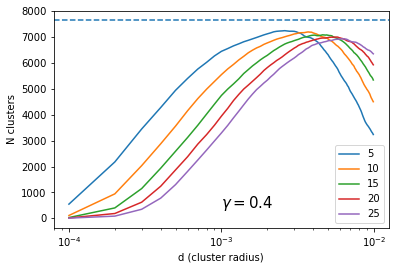

In [35]:

for dt in np.arange(5, 30, 5):
    pixels=list(pix_runs.keys())
    ds = pix_runs[pixels[0]][dt][0]
    nclusters = pix_runs[pixels[0]][dt][1]
    nerrors = pix_runs[pixels[0]][dt][2]
    for pix in pixels[1:]:
        nclusters = list(map(add, nclusters, pix_runs[pix][dt][1]))
        nerrors = list(map(add, nerrors, pix_runs[pix][dt][2]))
    nclusters=np.array(nclusters)
    
    plt.plot(ds, nclusters, label=dt)

plt.xscale("log", nonposx='clip')
plt.axhline(true_count, ls='dashed')
plt.xlabel('d (cluster radius)')
plt.ylabel('N clusters')
plt.text(0.001, 400, r'$\gamma=0.4$', fontsize=15)
plt.legend()
plt.savefig('nclusters_vs_d_z2.5.pdf')
plt.show()
# 

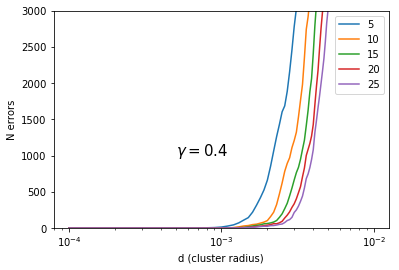

In [36]:
for dt in np.arange(5, 30, 5):
    pixels=list(pix_runs.keys())
    ds = pix_runs[pixels[0]][dt][0]
    nclusters = pix_runs[pixels[0]][dt][1]
    nerrors = pix_runs[pixels[0]][dt][2]
    for pix in pixels[1:]:
        nclusters = list(map(add, nclusters, pix_runs[pix][dt][1]))
        nerrors = list(map(add, nerrors, pix_runs[pix][dt][2]))
    nclusters=np.array(nclusters)
    nerrors=np.array(nerrors)
            
    
    plt.plot(ds, nerrors, label=dt)

plt.xscale("log", nonposx='clip')
plt.ylim((0,3000))
plt.xlabel('d (cluster radius)')
plt.ylabel('N errors')
plt.text(0.0005, 1000, r'$\gamma=0.4$', fontsize=15)
plt.legend()
plt.savefig('nerrors_vs_d_z2.5.pdf')
plt.show()
# 



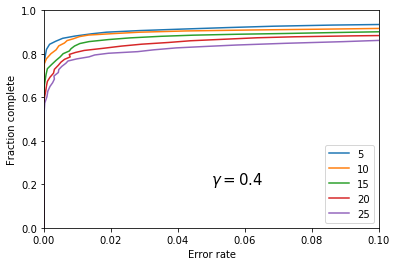

In [37]:

for dt in np.arange(5, 30, 5):
    pixels=list(pix_runs.keys())
    ds = pix_runs[pixels[0]][dt][0]
    nclusters = pix_runs[pixels[0]][dt][1]
    nerrors = pix_runs[pixels[0]][dt][2]
    for pix in pixels[1:]:
        nclusters = list(map(add, nclusters, pix_runs[pix][dt][1]))
        nerrors = list(map(add, nerrors, pix_runs[pix][dt][2]))
    nclusters=np.array(nclusters)
    nerrors=np.array(nerrors)    
    
    plt.plot(nerrors/true_count, nclusters/true_count, label=dt)

plt.xlim((0.0001, 0.1))
#plt.xscale("log", nonposx='clip')
plt.ylim((0, 1))
plt.xlabel('Error rate')
plt.ylabel('Fraction complete')
plt.text(0.05, 0.2, r'$\gamma=0.4$', fontsize=15)
plt.legend()
plt.savefig('AUCish_z2.5.pdf')
plt.show()
# 




I want to plot where the errors are occurring, to see if they are happening near quadrature.  It doesn't seem to be the case.

Here's a working goal.  Let's try to achieve 90% completeness with minimal errors.  From the runs I have done, dt=20 does achieve 90% completeness, with a 4% error rate.  

I can try a few more dt values, around 20.

An alternative approach is to aim to be less complete but with a lower error rate.  And then remove those clusters and iterate.  

The errors are false positives.  That is, we say they are clusters, but they are at least contaminated.

From the plot below it looks like we want dt=10 days, a completeness of 85%, and an error rate of 1%.  We achieve that at d=0.0008.

Actually, if we go with dt=50 days, we can achieve 50% completeness with not recorded errors (or an error rate of less than 0.1%.  Why don't we do with that for a first passs?



In [38]:
error_rate_limit=1e-3
training_dict={}
for n in [-11, -14, -17, -20, -23]:
    infilename='data/UnnObs_Training_1_line_A_%.1lf_pm15.0_r2.5.trans' % (lunation_center(n))
    pickle_filename = infilename.rstrip('trans') + 'v2_pickle'
    dt=15
    with open(pickle_filename, 'rb') as handle:
        pix_runs = pickle.load(handle)
    
        # Should save these results in files
        true_count_dict, mergedCounter_dict, mergedTime_dict=accessible_clusters(list(pix_runs.keys()), infilename=infilename)
        true_count=sum(true_count_dict.values())
        true_count

        print(n)
        for i in range(99):
            errs=0
            clusts=0
            trues=0
            for pix in list(pix_runs.keys()):
                nclusters = pix_runs[pixels[pix]][dt][1][i]
                nerrors = pix_runs[pixels[pix]][dt][2][i]
                ntrue = true_count_dict[pix]

                errs += nerrors
                clusts += nclusters
                trues += ntrue
            if float(errs)/trues<error_rate_limit:
                print(i, pix_runs[pixels[pix]][dt][0][i], errs, clusts, trues)
            else:
                training_dict[n] = pix_runs[pixels[pix]][dt][0][i], errs, clusts, trues
                break

-11
0 0.0001 0 7 3779
1 0.0002 0 75 3779
2 0.0003 0 246 3779
3 0.0004 0 519 3779
4 0.0005 0 795 3779
5 0.0006 0 1031 3779
6 0.0007 1 1292 3779
7 0.0008 3 1509 3779
-14
0 0.0001 0 28 7643
1 0.0002 0 400 7643
2 0.0003 0 1148 7643
3 0.0004 0 1936 7643
4 0.0005 0 2588 7643
5 0.0006 0 3121 7643
6 0.0007 0 3594 7643
7 0.0008 0 4028 7643
8 0.0009 0 4409 7643
9 0.001 0 4745 7643
10 0.0011 1 4992 7643
11 0.0012 3 5192 7643
12 0.0013 5 5387 7643
-17
0 0.0001 0 0 1607
1 0.0002 0 10 1607
2 0.0003 0 88 1607
3 0.0004 0 183 1607
4 0.0005 0 312 1607
5 0.0006 0 439 1607
6 0.0007 0 562 1607
7 0.0008 0 681 1607
8 0.0009 0 798 1607
9 0.001 0 892 1607
10 0.0011 0 962 1607
11 0.0012 0 1026 1607
-20
0 0.0001 0 29 3957
1 0.0002 0 353 3957
2 0.0003 0 850 3957
3 0.0004 0 1279 3957
4 0.0005 0 1625 3957
5 0.0006 0 1905 3957
6 0.0007 0 2146 3957
7 0.0008 0 2350 3957
8 0.0009 0 2511 3957
9 0.001 0 2663 3957
10 0.0011 0 2774 3957
11 0.0012 0 2849 3957
12 0.0013 0 2916 3957
13 0.0014 0 2983 3957
14 0.0015 0 3021 3957

Here's the average of the cluster radii that yield the highest completeness for an error rate less than 0.1%.

In [39]:
cluster_radius = np.mean([v[0] for k, v in training_dict.items()])
cluster_radius

0.00124

In [40]:
gs = [0.3, 0.35, 0.4, 0.45, 0.5]
gs =[0.4]
gdots = [-0.004, -0.003, -0.002, -0.001, 0.0, 0.001, 0.002, 0.003, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

def do_test_run(pixels, infilename, t_ref, 
                    cluster_sky_function=cluster_sky_regions,
                    g_gdots=g_gdots, mincount=3, 
                    dt=15,
                    rad=0.00124):                
    
    master = cluster_sky_function(g_gdots, pixels, t_ref, infilename)

    results_dict={}
    rates_dict={}
    cluster_counter = Counter()
    for pix, d in master.items():
        for z_zdot, arrows in d.items():

            # The bit from here
            i = 0
            label_dict={}
            combined=[]
            for k, cx, mx, cy, my, t in arrows:
                label_dict[i] = k
                combined.append([cx, mx*dt, cy, my*dt])
                i +=1
            points=np.array(combined)
            # to here can be a function,
            # that takes arrows and dt and
            # returns label_dict and points array
            
            # The bit from here
            tree = scipy.spatial.cKDTree(points)
            matches = tree.query_ball_tree(tree, rad)
            # to here can be a function, that takes
            # points are rad and returns tree and
            # matches
                    
            for j, match in enumerate(matches):
                if len(match)>=mincount:
                    # From here is about making a cluster key 
                    # from the indices and label dictionary
                    cluster_list =[]
                    for idx in match:
                        cluster_list.append(label_dict[idx].strip())
                        #tracklet_params.append(combined[idx])
                    cluster_key='|'.join(sorted(cluster_list))
                    # to here
                    
                    cluster_counter.update({cluster_key: 1})
            
    test_set = list(cluster_counter.keys()) 
    success_dict, failure_counter = unique_clusters(test_set)
   
    values = len(success_dict), len(failure_counter), list(success_dict.keys()), list(failure_counter.keys())

    return values

Here I am timing a run

In [41]:
test_runs={}
for n in [-14]:
    test_runs = {}
    infilename='data/UnnObs_Training_1_line_A_%.1lf_pm15.0_r2.5.trans' % (lunation_center(n))
    pickle_filename = infilename.rstrip('trans') + 'test.pickle'
    t_ref=lunation_center(n)
    pixels=range(hp.nside2npix(nside))
    test_runs[n] = do_test_run(pixels, infilename, t_ref, mincount=2, rad=0.003)
    with open(pickle_filename, 'wb') as handle:
        pickle.dump(test_runs, handle, protocol=pickle.HIGHEST_PROTOCOL)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

AttributeError: 'list' object has no attribute 'keys'

In [77]:
gs = [0.3, 0.35, 0.4, 0.45, 0.5]
gs =[0.4]
gdots = [-0.004, -0.003, -0.002, -0.001, 0.0, 0.001, 0.002, 0.003, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

def do_run(pixels, infilename, t_ref, 
                    cluster_sky_function=cluster_sky_regions,
                    g_gdots=g_gdots, mincount=3, 
                    dt=15,
                    rad=0.00124):                
    
    master = cluster_sky_function(g_gdots, pixels, t_ref, infilename)

    results_dict={}
    rates_dict={}
    cluster_counter = Counter()
    for pix, d in master.items():
        for z_zdot, arrows in d.items():

            # The bit from here
            i = 0
            label_dict={}
            combined=[]
            for k, cx, mx, cy, my, t in arrows:
                label_dict[i] = k
                combined.append([cx, mx*dt, cy, my*dt])
                i +=1
            points=np.array(combined)
            # to here can be a function,
            # that takes arrows and dt and
            # returns label_dict and points array
            
            # The bit from here
            tree = scipy.spatial.cKDTree(points)
            matches = tree.query_ball_tree(tree, rad)
            # to here can be a function, that takes
            # points are rad and returns tree and
            # matches
                    
            for j, match in enumerate(matches):
                if len(match)>=mincount:
                    # From here is about making a cluster key 
                    # from the indices and label dictionary
                    cluster_list =[]
                    for idx in match:
                        cluster_list.append(label_dict[idx].strip())
                        #tracklet_params.append(combined[idx])
                    cluster_key='|'.join(sorted(cluster_list))
                    # to here
                    
                    cluster_counter.update({cluster_key: 1})
            
    return cluster_counter

In [43]:
for n in [-14]:
    runs = {}
    infilename='data/UnnObs_Training_1_line_A_%.1lf_pm15.0_r2.5.trans' % (lunation_center(n))
    pickle_filename = infilename.rstrip('trans') + 'test.pickle'
    t_ref=lunation_center(n)
    pixels=range(hp.nside2npix(nside))
    runs[n] = do_run(pixels, infilename, t_ref, mincount=3, rad=0.00300)
    with open(pickle_filename, 'wb') as handle:
        pickle.dump(runs, handle, protocol=pickle.HIGHEST_PROTOCOL)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [44]:
runs

{-14: Counter({'K15TK2M_003|K15TK2M_004|K15TK2M_005|K15TK2M_006|K15TK2M_007': 9,
          'K12B55B_026|K12B55B_027|K12B55B_028|K12B55B_031': 3,
          'K14E10Y_016|K14E10Y_018|K14E10Y_019|K14E10Y_020': 1,
          'K15RJ2L_006|K15RJ2L_007|K15RJ2L_008': 82,
          'K15TF2E_003|K15TF2E_004|K15TF2E_005|K15TF2E_006|K15TF2E_007': 208,
          'K15TD0X_003|K15TD0X_004|K15TD0X_005': 3,
          'K15R90U_011|K15R90U_012|K15R90U_013': 15,
          'K15TK6Y_002|K15TK6Y_003|K15TK6Y_004': 239,
          'K02QF5J_021|K02QF5J_022|K02QF5J_023|K02QF5J_024|K02QF5J_025': 140,
          'K15TJ8B_013|K15TJ8B_014|K15TJ8B_015': 3,
          'K15TJ8A_004|K15TJ8A_005|K15TJ8A_006': 9,
          'K15T73C_002|K15T73C_003|K15T73C_005': 1,
          'K15TH8K_001|K15TH8K_002|K15TH8K_004|K15TH8K_006|K15TH8K_007|K15TH8K_008|K15TH8K_009|K15TH8K_010|K15TH8K_011|K15TH8K_012': 9,
          'K06R40G_022|K06R40G_023|K06R40G_024': 1,
          'K15V14U_002|K15V14U_003|K15V14U_004': 36,
          'K15TJ1V_006|K15

In [45]:
def member_counts(k, sep='|', suff='_'):
    keys = k.split(sep)
    stems = [key.split(suff)[0] for key in keys]
    stem_counter = Counter(stems)
    return stem_counter

def unique_clusters(test_set):
    success_dict = {}
    failure_counter = Counter()
    for k in test_set:
        stem_counter = member_counts(k)
        if len(stem_counter)>1:
            failure_counter.update({k:1})
        else:
            for stem, v in stem_counter.items():
                if stem not in success_dict:
                    success_dict[stem] = v, k
                elif v > success_dict[stem][0]:
                    success_dict[stem] = v, k
    return success_dict, failure_counter


In [47]:
def get_original_tracklets_dict(filename='data/UnnObs_Training_1_line_A.mpc'):
    tracklets = defaultdict(list)
    with open(filename) as infile:
        for i, line in enumerate(infile):
            if not line.startswith('#'):
                desig = line[0:12].strip()
                tracklets[desig].append(i)
    return tracklets

In [48]:
def get_original_observation_array(filename='data/UnnObs_Training_1_line_A.txt'):
    tracklets = defaultdict(list)
    with open(filename) as infile:
        data = infile.readlines()
    return data

In [49]:
UnnObs_tracklets_dict = get_original_tracklets_dict()
UnnObs_obs_array = get_original_observation_array()

In [50]:
def get_observations(cluster_key, tracklets_dict, observation_array, sep='|'):
    array=[]
    for key in cluster_key.split(sep):
        indices = tracklets_dict[key]
        for idx in indices:
            array.append(observation_array[idx].rstrip())
    return array


In [51]:
obs_dict={}
for n, result in runs.items():
    for cluster_key in result.keys():
        obs_dict[cluster_key] = get_observations(cluster_key, UnnObs_tracklets_dict, UnnObs_obs_array)

n=-14
pickle_filename = "run_%d_v2.pickle" %(n)
with open(pickle_filename, 'wb') as handle:
    pickle.dump(obs_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [56]:
len(obs_dict)

4806

In [57]:
obs_dict

{'K15TK2M_003|K15TK2M_004|K15TK2M_005|K15TK2M_006|K15TK2M_007': ['     K15TK2M  C2015 10 11.33320 02 41 53.84 -00 11 14.2          19.6 rR~1YkIG45',
  '     K15TK2M  C2015 10 11.33963 02 41 53.61 -00 11 18.2          19.6 rR~1YkIG45',
  '     K15TK2M  C2015 10 11.33970 02 41 53.59 -00 11 18.6          19.7 rR~1YkIG45',
  '     K15TK2M  C2015 10 11.34674 02 41 53.39 -00 11 22.6          19.6 rR~1YkIG45',
  '     K15TK2M  C2015 10 11.35075 02 41 53.29 -00 11 24.8          19.9 rR~1YkIG45',
  '     K15TK2M  C2015 10 11.35082 02 41 53.29 -00 11 24.9          19.6 rR~1YkIG45',
  '     K15TK2M  C2015 10 12.43311 02 41 23.650-00 22 18.07         19.3 wL~1dfXF51',
  '     K15TK2M  C2015 10 12.45764 02 41 22.882-00 22 32.96         19.5 wL~1dfXF51',
  '     K15TK2M  C2015 10 12.46992 02 41 22.493-00 22 40.33         19.4 wL~1dfXF51',
  '     K15TK2M  C2015 10 13.42042 02 40 54.918-00 32 13.63         19.3 wL~1agNF51',
  '     K15TK2M  C2015 10 13.43456 02 40 54.449-00 32 22.13         19.3 wL~1

In [53]:
lunation_center(-14)

2457308.5

In [54]:
pickle_filename = "run_%d.pickle" %(n)
with open(pickle_filename, 'rb') as handle:
    obs_dict = pickle.load(handle)

In [ ]:
# Should just passing the selection function, to avoid code duplication
def generate_sky_region_files(infilename='data/itf_new_1_line_2457397.5_pm15.0_r2.5.trans', nside=8, n=-11, angDeg=5.5, g=0.4, gdot=0.0):
    hp_dict = defaultdict(list)
    with open(infilename) as file:
        for line in file:
            if line.startswith('#'):
                continue
            pix = int(line.split()[-1])
            hp_dict[pix].append(line)

    for i in range(hp.nside2npix(nside)):
        vec = hp.pix2vec(nside, i, nest=True)
        neighbors = hp.query_disc(32, vec, angDeg*np.pi/180., inclusive=True, nest=True)
        lines = []
        for pix in neighbors:
            for line in hp_dict[pix]:
                lines.append(line)
        outfilename = infilename.rstrip('.trans') + '_hp_' + ('%03d' % (i)) + '_g'+ ('%.2lf' % (g))+'_gdot' + ('%+5.1le' % (gdot))
        if len(lines) > 0:
            select_positions_z(lunation_center(n), g, gdot, vec, lines, outfilename)





In [ ]:
lunation_center(-15)

In [ ]:
generate_sky_region_files(infilename='data/UnnObs_Training_1_line_A_2457279.5_pm15.0_r2.5.trans', n=-15)

In [ ]:
z0=3.0
for n in range(-11, -9):
    infilename = 'itf_new_1_line_'+str(lunation_center(n))+'_pm15.0_r2.5.trans'
    print(infilename)
    generate_sky_region_files(infilename=infilename, n=n, z0=z0)

        

In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

def make_figure(filename):
    plt.ioff()
    mxs, cxs, mys, cys, dts =[], [], [], [], []
    for line in open(filename):
        if line.startswith('#'):
            continue
        desig, cx, mx, cy, my, dt = line.split()
        mxs.append(float(mx))
        cxs.append(float(cx))
        mys.append(float(my))
        cys.append(float(cy))
        dts.append(float(dt))
    
    fig=plt.figure(figsize=(18, 16))

    #norm = Normalize()
    #norm.autoscale(colors)
    
    colormap = cm.inferno

    plt.quiver(cxs, cys, mxs, mys, dts, scale=0.3, width=0.0003)

    plt.xlim(-0.2, 0.2)
    plt.ylim(-0.2, 0.2)
    plt.xlabel('alpha')
    plt.ylabel('beta')
    outfile = filename+'.pdf'
    plt.savefig(outfile)
    plt.close()
    plt.ion()


In [ ]:
def make_figure_zoom(filename):
    plt.ioff()
    mxs, cxs, mys, cys, dts =[], [], [], [], []
    for line in open(filename):
        if line.startswith('#'):
            continue
        desig, cx, mx, cy, my, dt = line.split()
        mxs.append(float(mx))
        cxs.append(float(cx))
        mys.append(float(my))
        cys.append(float(cy))
        dts.append(float(dt))
    
    fig=plt.figure(figsize=(18, 16))

    #norm = Normalize()
    #norm.autoscale(colors)
    
    colormap = cm.inferno

    plt.quiver(cxs, cys, mxs, mys, dts, scale=0.3, width=0.0003)

    plt.xlim(-0.1, 0.1)
    plt.ylim(-0.1, 0.1)
    plt.xlabel('alpha')
    plt.ylabel('beta')
    outfile = filename+'_zm.pdf'
    plt.savefig(outfile)
    plt.close()
    plt.ion()

In [ ]:
lunation_center(-11)

In [ ]:
zdot0=+2.5e-3
for z0 in [2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5]:
    for n in range(-11, -10):
        infilename = 'data/UnnObs_Training_1_line_A_'+str(lunation_center(n))+'_pm45.0_r2.5.trans'
        print(infilename)
        generate_sky_region_files_v2(infilename=infilename, n=n, z0=z0, zdot0=zdot0)



In [ ]:
n=-15
gs = [0.4]
gdots = [-0.004, -0.003, -0.002, -0.001, 0.0, 0.001, 0.002, 0.003, 0.004]
for gdot in gdots:
    infilename = 'data/UnnObs_Training_1_line_A_'+str(lunation_center(n))+'_pm45.0_r2.5.trans'
    print(infilename)
    generate_sky_region_files(infilename=infilename, n=n, g=g, gdot=gdot)


In [ ]:
z0=3.1
for zdot0 in [-1.0e-2, -8.0e-3, -6.0e-3, -4.0e-3, -2.0e-3, 0.0e-3, 2.0e-3, 4.0e-3, 6.0e-3, 8.0e-3, 1.0e-2]:
    for n in range(-11, -10):
        infilename = 'data/UnnObs_Training_1_line_A_'+str(lunation_center(n))+'_pm45.0_r2.5.trans'
        print(infilename)
        generate_sky_region_files_v2(infilename=infilename, n=n, z0=z0, zdot0=zdot0)



In [ ]:
z0=3.1
for zdot0 in [-1.0e-2, -8.0e-3, -6.0e-3, -4.0e-3, -2.0e-3, 0.0e-3, 2.0e-3, 4.0e-3, 6.0e-3, 8.0e-3, 1.0e-2]:
    for n in range(-11, -10):
        infilename = 'data/UnnObs_Training_1_line_A_'+str(lunation_center(n))+'_pm45.0_r2.5.trans'
        filename = infilename.rstrip('.trans') + '_hp_378' + ('_z%4.2lf_zdot%+3.1le_v2' % (z0, zdot0))
        make_figure(filename)
        make_figure_zoom(filename)
        

In [ ]:
gs = [0.4]
gdots = [-0.004, -0.003, -0.002, -0.001, 0.0, 0.001, 0.002, 0.003, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

n=-15
for g_gdot in g_gdots:
    g, gdot = g_gdot
    infilename = 'data/UnnObs_Training_1_line_A_'+str(lunation_center(n))+'_pm45.0_r2.5.trans'
    filename = infilename.rstrip('.trans') + '_hp_000' + ('_g%4.2lf_gdot%+3.1le' % (g, gdot))
    make_figure(filename)
    


In [ ]:
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.00_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.10_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.20_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.30_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.40_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.50_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.60_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.70_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.80_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.90_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z3.00_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z3.10_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z3.20_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z3.30_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z3.40_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z3.50_zdot+2.5e-03_v2')

In [ ]:
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.00_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.10_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.20_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.30_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.40_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.50_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.60_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.70_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.80_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.90_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z3.00_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z3.10_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z3.20_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z3.30_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z3.40_zdot+2.5e-03_v2')
make_figure('data/UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z3.50_zdot+2.5e-03_v2')

In [ ]:
make_figure('UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.50_zdot+0.0e+00')
make_figure('UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.50_zdot+5.0e-03')
make_figure('UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.50_zdot-5.0e-03')
make_figure('UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.50_zdot+2.5e-03')
make_figure('UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.50_zdot-2.5e-03')
make_figure('UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.50_zdot+7.5e-03')
make_figure('UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.50_zdot-7.5e-03')

In [ ]:
make_figure('UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z3.00_zdot+0.0e+00')
make_figure('UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z3.00_zdot+5.0e-03')
make_figure('UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z3.00_zdot-5.0e-03')
make_figure('UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z3.00_zdot+2.5e-03')
make_figure('UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z3.00_zdot-2.5e-03')
make_figure('UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z3.00_zdot+7.5e-03')
make_figure('UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z3.00_zdot-7.5e-03')

In [ ]:
make_figure('UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.00_zdot+0.0e+00')
make_figure('UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.00_zdot+5.0e-03')
make_figure('UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.00_zdot-5.0e-03')
make_figure('UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.00_zdot+2.5e-03')
make_figure('UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.00_zdot-2.5e-03')
make_figure('UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.00_zdot+7.5e-03')
make_figure('UnnObs_Training_1_line_A_2457397.5_pm45.0_r2.5_hp_378_z2.00_zdot-7.5e-03')

Here's a game plan:

* Verify the dark time numbers --DONE.
* Stick with a smallish time window (+/- 15 days) --DONE.
* Do heliocentric transformation for r=2.5 AU (rdot=0) --DONE.
* Do selection_positions_z for all the time slices.  This will generate a large number of files.
* Identify the largest files.  Find a way to not generate empty files.
* Run clustering on each file, identifying candidate clusters.
* Somehow vet the candidate clusters.  I can think of three ways: (1) use Gareth's code, (2) use Bernstein's code, or (3) fit a simple linear model.   The third would be a very quick way of clustering tracklets within a lunation.

The r2.5 run is just to separate the tracklets into sky regions.  Given those sky regions, I can examine a runs of z and zdot.  It seems that a simple grid of a few values in z (3 or 4) and zdot (7 or 8) might be enough.

Perhaps it is possible to do all the clustering for a sky region of a given time slice all in one pass.  It's not necessary to write out the intermediate files.  Given a set of tracklets, transform for a (z, zdot) value and then search for clusters.

If a cluster is found, make a key of the tuple of sorted trackletIDs and then add that key to a dictionary or counter. 

Here's a new game plan:

* Select 5 different disjoint time slices.  These will be +/- 15 days and +/- 45 days.
* Run the training on those time slices for all sky regions for both +/- 15 days and +/- 45 days.  The former requires only the gamma-dot parameter to be varied, for a few values of gammma.  The latter probably requires a finer grid in gamma and gamma-dot.  In both cases, the hyperparameters that we are tuning are the cluster radius and the time factor dt.
* If I want to do repeated universal kepler steps, I need to make that fast in python.

I want to plan how to process all the months of the ITF.

The parameters are dt=15 days and rad=0.0020 radians.  This yields high completeness and a low error rate.

For each time slice:



In [68]:
lunation_center(-823)

2433418.5

In [ ]:
import os.path

itf_runs={}
for n in range(-124, 11):
    infilename='data/itf_new_1_line_%.1lf_pm15.0_r2.5.trans' % (lunation_center(n))
    print(n, infilename)
    if not os.path.isfile(infilename):
        continue
    pickle_filename = infilename.rstrip('trans') + 'test.pickle'
    t_ref=lunation_center(n)
    pixels=range(hp.nside2npix(nside))
    itf_runs[n] = do_run(pixels, infilename, t_ref, mincount=3, rad=0.00200)
    with open(pickle_filename, 'wb') as handle:
        pickle.dump(itf_runs, handle, protocol=pickle.HIGHEST_PROTOCOL)

-124 data/itf_new_1_line_2454060.5_pm15.0_r2.5.trans
-123 data/itf_new_1_line_2454089.5_pm15.0_r2.5.trans
-122 data/itf_new_1_line_2454119.5_pm15.0_r2.5.trans
-121 data/itf_new_1_line_2454148.5_pm15.0_r2.5.trans
-120 data/itf_new_1_line_2454178.5_pm15.0_r2.5.trans
-119 data/itf_new_1_line_2454207.5_pm15.0_r2.5.trans
-118 data/itf_new_1_line_2454237.5_pm15.0_r2.5.trans
-117 data/itf_new_1_line_2454266.5_pm15.0_r2.5.trans
-116 data/itf_new_1_line_2454296.5_pm15.0_r2.5.trans
-115 data/itf_new_1_line_2454325.5_pm15.0_r2.5.trans
-114 data/itf_new_1_line_2454355.5_pm15.0_r2.5.trans
-113 data/itf_new_1_line_2454385.5_pm15.0_r2.5.trans
-112 data/itf_new_1_line_2454414.5_pm15.0_r2.5.trans
-111 data/itf_new_1_line_2454444.5_pm15.0_r2.5.trans
-110 data/itf_new_1_line_2454473.5_pm15.0_r2.5.trans
-109 data/itf_new_1_line_2454503.5_pm15.0_r2.5.trans
-108 data/itf_new_1_line_2454532.5_pm15.0_r2.5.trans
-107 data/itf_new_1_line_2454562.5_pm15.0_r2.5.trans
-106 data/itf_new_1_line_2454591.5_pm15.0_r2.5

In [ ]:
import sys, requests
str = 'blah, blah, blah'
payload = {'source': str.rstrip("\n")}
r = requests.get('https://minorplanetcenter.net/mpc_orbit', params=payload)
print(r.text)

In [ ]:
8*30